# <font color='red'> End to End Deep Learning For Self Driving Cars </font>

## 1. Problem Statement.

* __This project is to build a model which can aid a car to drive on it's own by predicting the steering angle.__

## 2. Data Overview

* The dataset contains ~45K images with respective steering angles.
* The dataset constitutes to ~25 minutes continuos video of driving.
* The dataset can be obtained from [SullyChen's Github](https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]) which was recorded by himself.
* The steering angles are located in data.txt with their respective images.

## 3. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
from skimage.transform import resize

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### 3.1 Loading the data

In [12]:
df = pd.read_csv('data.txt', delimiter=' ', header=None)
df.columns = ['image_id', 'angle_deg']
df.sample(5)

,image_id,angle_deg
30625,30625.jpg,38.92
24097,24097.jpg,-4.03
15047,15047.jpg,0.00
24079,24079.jpg,0.20
22830,22830.jpg,-2.52


In [13]:
FPS = 30 #the camera can click 30 images per second
MIN = 60 #seconds
print(f"Number of images in data(discrete)                      : {df.shape[0]}")
print(f"Length of the image data in continuos form(video 30fps) : {df.shape[0]/(MIN * FPS) : .3f} MIN")

Number of images in data(discrete)                      : 45406
Length of the image data in continuos form(video 30fps) :  25.226 MIN


### 3.2 Convert the angle to radians

In [14]:
print(f"range of angle in degrees : ({df.angle_deg.min()}, {df.angle_deg.max()})")

range of angle in degrees : (-159.93, 501.78)


__<font color='green'> OBSERVATIONS </font>__

* The steering angles are measured relative to a fixed point.
* The range of angle in degrees is spread across much wider distribution with high range of values.
* Such large values can cause large gradients to flow in the network and cause unstability.
* The radians scale is much better with values ranging on a smaller scale.

In [15]:
df['angle_rad'] = np.deg2rad(df.angle_deg.values)
df.sample(5)

,image_id,angle_deg,angle_rad
14552,14552.jpg,-8.87,-0.154811
18415,18415.jpg,1.82,0.031765
4078,4078.jpg,17.34,0.302640
2318,2318.jpg,1.61,0.028100
30449,30449.jpg,52.34,0.913505


In [95]:
print(f"range of angle in radians : ({df.angle_rad.min() : .3f}, {df.angle_rad.max() : .3f})")

range of angle in radians : (-2.791,  8.758)


### 3.3 Train and Test Split

* As we've have the temporal info of the images, let's split the data by time.
* The train and test splits are done in raton by 70:30.

In [17]:
split_index = int(df.shape[0] * 0.7)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]
test_df.reset_index(inplace=True)

print(f"Number of Images in TRAIN_DF : {train_df.shape[0]}")
print(f"Number of Images in TEST_DF  : {test_df.shape[0]}")

Number of Images in TRAIN_DF : 31784
Number of Images in TEST_DF  : 13622


__HISTOGRAM OF ANGLES IN RADIANS__

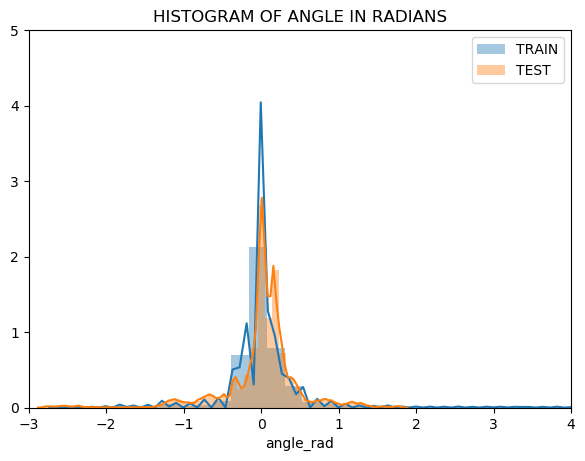

In [18]:
plt.figure(figsize=(7, 5), dpi=100)
sns.distplot(train_df.angle_rad, label='TRAIN')
sns.distplot(test_df.angle_rad, label='TEST')
plt.title('HISTOGRAM OF ANGLE IN RADIANS')
plt.axis([-3, 4, 0, 5])
plt.legend()
plt.show()

__<font color='green'> OBSERVATIONS </font>__

* From the above plot, most of the values are centered around zero. This might make our model drive straight.
* We'll have to take preventive measures to overcome this.

## 4. Modelling

### 4.1 Simple Baseline Model

In [19]:
print(f"TEST MSE if pred angle == mean of TRAIN angle : {((test_df.angle_rad - train_df.angle_rad.mean())**2).mean() : .5f}")
print(f"TEST MSE if pred angle == ZERO                : {((test_df.angle_rad - 0)**2).mean() : .5f}")

TEST MSE if pred angle == mean of TRAIN angle :  0.24156
TEST MSE if pred angle == ZERO                :  0.24111


__<font color='green'> OBSERVATIONS </font>__

* The baseline model can be viewed as the upper bound to measure the performance of the CNN we build.

### 4.2 ConvNet

In [10]:
from keras.layers import Conv2D, Dropout, Dense, Flatten, Input
from keras.layers import Lambda, BatchNormalization, Activation
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.utils import Sequence
import tensorflow as tf

Using TensorFlow backend.


__MOVING THE IMAGES TO SEPERATE FOLDERS__

In [14]:
if not os.path.exists('image_data/'):
    os.makedirs('image_data')
else:
    print('directory already exists')

directory already exists


In [15]:
dst_train = 'image_data/train'
if not os.path.exists(dst_train):
    os.makedirs(dst_train)
    
    print(f'moving images to directory : {dst_train}')
    for image_id in TRAIN.image_id.values:
        shutil.move(f'driving_dataset/{image_id}', dst_train)

    print(f"Number of images in TRAIN : {len(os.listdir(dst_train))}")
    
else:
    print(f"directory : {dst_train} already exists")

directory : image_data/train already exists


In [16]:
dst_test = 'image_data/test'
if not os.path.exists(dst_test):
    os.makedirs(dst_test)

    print(f'moving images to directory : {dst_test}')
    for image_id in TEST.image_id.values:
        shutil.move(f'driving_dataset/{image_id}', dst_test)

    print(f"Number of images in TRAIN : {len(os.listdir(dst_test))}")
else:
    print(f"directory : {dst_test} already exists")

directory : image_data/test already exists


__IMAGE DATA GENERATOR__

* The size of the image data makes it hard to store all the images into memory.
* We'll build a Image Generator Class which inherits from keras.utils.Sequence Class.
* This Class returns a batch of images when calledby specific batch_index.
* This Class uses mutiprocessing on the cpu to generate multiple batches at once which can be pickled.
* Generators(yield) aren't used due to their unpicklable nature.
* jupyter doesn't support multiprocessing functionality if the code to be parallelized exists within the same notebook. 
* Move the script in the cell below in a seperate .py file.
* code inspired from [Stanford Blog](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly)

In [17]:
"""
#inherit the Sequence Class from keras.utils
class ImageDataGenerator(Sequence):
    
    def __init__(self, data_dir, target_shape, batch_size, df, x_col, y_col, shuffle=False):
        self.data_dir = None
        self.target_shape = target_shape
        self.batch_size = batch_size
        self.filenames = df[x_col].values
        self.targets = df[y_col].values
        self.num_samples = len(self.filenames)
        self.num_batches = (self.num_samples  // self.batch_size) + 1
        self.shuffle = shuffle
        self.indices = np.arange(self.num_samples)
        
        if os.path.exists(data_dir):
            self.data_dir = data_dir
        else:
            raise FileNotFoundError("FileNotFound")
            
        if self.shuffle:
            np.random.shuffle(self.indices)
             
            
    #these two functions below are necessary for building the image generator
        
    def __len__(self): 
        return self.num_batches
    
        
    #infinite images generator
    def __getitem__(self, batch_index):
              
        batch_idxs = self.indices[batch_index*self.batch_size : (batch_index+1)*self.batch_size]
        batch_imgs = np.array([resize(imread(self.data_dir+f)[-150:], self.target_shape) for f in self.filenames[batch_idxs]])
        targets = np.reshape(self.targets[batch_idxs], (-1, 1))
        
        return (batch_imgs, targets)
"""
            
            

'\n#inherit the Sequence Class from keras.utils\nclass ImageDataGenerator(Sequence):\n    \n    def __init__(self, data_dir, target_shape, batch_size, df, x_col, y_col, shuffle=False):\n        self.data_dir = None\n        self.target_shape = target_shape\n        self.batch_size = batch_size\n        self.filenames = df[x_col].values\n        self.targets = df[y_col].values\n        self.num_samples = len(self.filenames)\n        self.num_batches = (self.num_samples  // self.batch_size) + 1\n        self.shuffle = shuffle\n        self.indices = np.arange(self.num_samples)\n        \n        if os.path.exists(data_dir):\n            self.data_dir = data_dir\n        else:\n            raise FileNotFoundError("FileNotFound")\n            \n        if self.shuffle:\n            np.random.shuffle(self.indices)\n             \n            \n    #these two functions below are necessary for building the image generator\n        \n    def __len__(self): \n        return self.num_batches\n  

In [21]:
from img_utils import ImageDataGenerator


train_generator = ImageDataGenerator(data_dir='image_data/train/',
                                     target_shape=(66, 200),
                                     batch_size=256,
                                     df=train_df,
                                     x_col='image_id',
                                     y_col='angle_rad')
                

test_generator = ImageDataGenerator(data_dir='image_data/test/',
                                    target_shape=(66, 200),
                                    batch_size=256,
                                    df=test_df,
                                    x_col='image_id',
                                    y_col='angle_rad')


__ARCHITECTURE__

* The below CNN architercture is inspired from [Nvidia's Blog](https://devblogs.nvidia.com/deep-learning-self-driving-cars/)
* 'tanh' activation with a scaling factor of 3 was used in the fully connected layers instead of relu.

In [75]:
def scale(X):
    from tensorflow import multiply, atan
    return multiply(atan(X), 4)
""
def driving_cnn():
    
    #No BatchNorm
    #relu in FC layers

    X_in = Input(shape=(66, 200, 3), name='input')
    
    X = Conv2D(filters=24, kernel_size=(5, 5), strides=(2, 2), kernel_initializer='he_normal')(X_in)
    X = BatchNormalization()(X)
    X = Activation('relu', name='act1')(X)
        
    X = Conv2D(filters=36, kernel_size=(5, 5), strides=(2, 2), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu', name='act2')(X)
    
    X = Conv2D(filters=48, kernel_size=(5, 5), strides=(2, 2), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu', name='act3')(X)
    
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu', name='act4')(X)
    
    X = Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), kernel_initializer='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu', name='act5')(X)
    
    X = Flatten()(X)
    for d in [1164, 200, 50, 10]:
        X = Dense(units=d, kernel_regularizer=l2(0.001))(X)
        X = BatchNormalization()(X)
        X = Activation('tanh')(X)
        #X = Lambda(scale)(X)
        X = Dropout(0.5)(X)
        
    X = Dense(units=1, activation='tanh')(X)
    X_out = Lambda(scale)(X)
    
    return Model(inputs=X_in, outputs=X_out)

In [76]:
model = driving_cnn()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
batch_normalization_46 (Batc (None, 31, 98, 24)        96        
_________________________________________________________________
act1 (Activation)            (None, 31, 98, 24)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
batch_normalization_47 (Batc (None, 14, 47, 36)        144       
_________________________________________________________________
act2 (Activation)            (None, 14, 47, 36)        0         
__________

In [71]:
#checkpoint the best model based on log_loss
filepath = 'saved_models/best_weights_relu_conv_tanh_fc_tanh_rad.h5'
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', save_best_only=True, save_weights_only=False)]

In [72]:
model.compile(optimizer=Adam(1e-4), loss='mse')

In [73]:
print(f"Input Batch Size        : {train_generator.batch_size}")
print(f"Num of batches in train : {train_generator.num_batches}")
print(f"Num of batches in test  : {test_generator.num_batches}")

Input Batch Size        : 256
Num of batches in train : 125
Num of batches in test  : 54


In [ ]:
model.fit_generator(generator=train_generator,
                    epochs=10,
                    validation_data=test_generator,
                    use_multiprocessing=True,
                    workers=6,
                    callbacks=callbacks_list)

In [77]:
model = load_model('saved_models/best_weights_relu_conv_tanh_fc_tanh_rad.h5')

__<font color='red'> TRAINING THE MODEL </font>__

* The range of the targets values in radians made it hard for the model.
* __tanh__ activation was used instead of __relu__ as the target values have negative numbers.
* The model was good at predicting values with in range [-1, 1] but failed to reach higher range.
* The model was trained with multiple learning rates.
    - 25 epochs with lr=1e-3
    - 10 epochs with lr=1e-4

In [60]:
test_mse = model.evaluate_generator(test_generator, use_multiprocessing=True, workers=6, verbose=1)
print(f'TEST MSE : {test_mse : .4f}')

54/54 [==============================] - 50s 922ms/step
TEST MSE :  0.1961


In [62]:
predictions = model.predict_generator(test_generator, use_multiprocessing=True, workers=6, verbose=1)

54/54 [==============================] - 52s 956ms/step


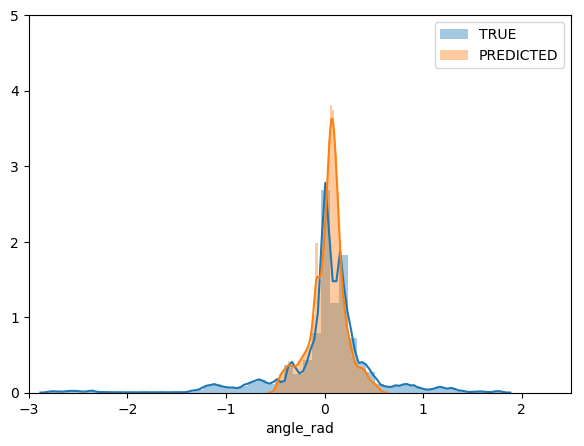

In [90]:
plt.figure(figsize=(7, 5), dpi=100)
sns.distplot(test_df.angle_rad, label='TRUE')
sns.distplot(predictions, label='PREDICTED')
plt.legend()
plt.axis([-3, 2.5, 0, 5])
plt.show()

__<font color='green'> OBSERVATIONS </font>__

* Most data points in the test data have steering angle around zero.
* Some the model is biased to driving straight.
* Data augmentation might help us achieve better results.

### 4.3 Interpreting the model

* We'll pass an image through the network as see the activation maps at first layer.
* We can verify whether the model has learnt anything useful.

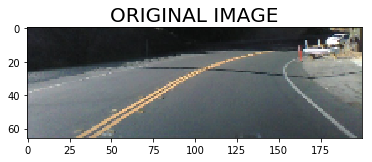

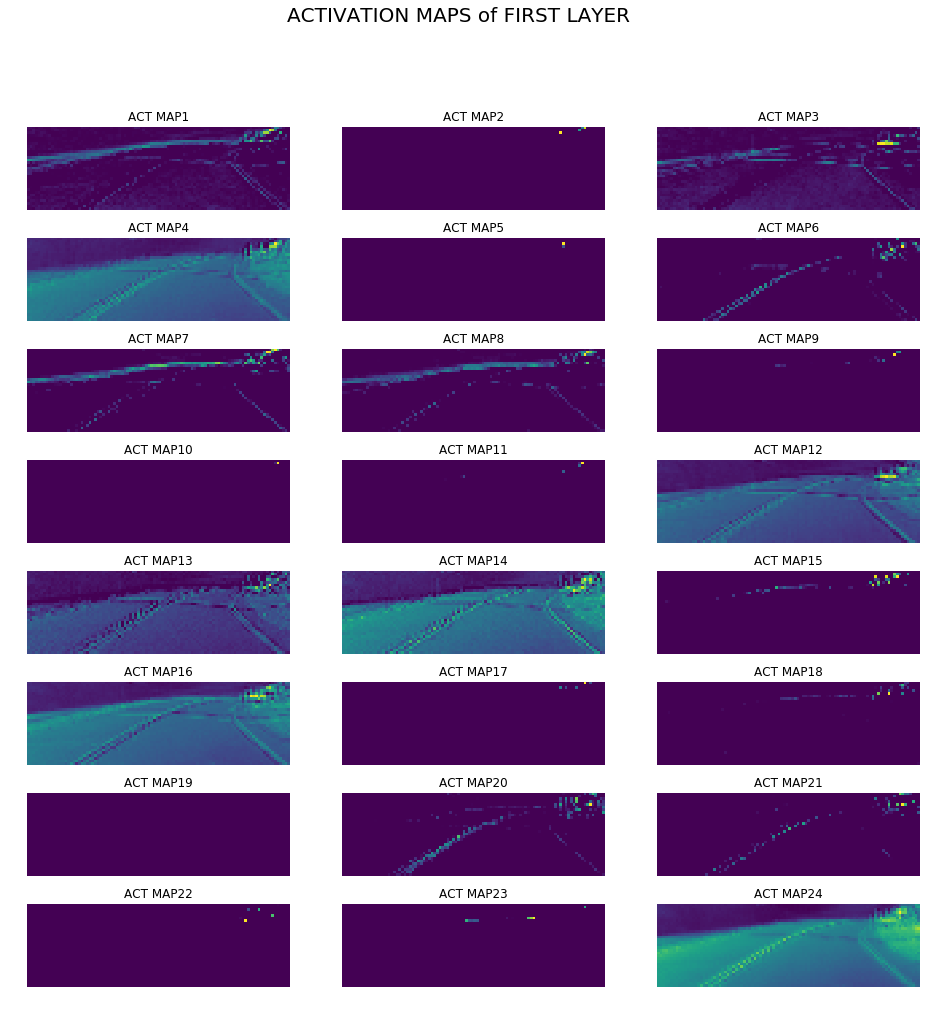

In [96]:
X_in = test_generator[10][0][25]
plt.title('ORIGINAL IMAGE', fontsize=20)
plt.imshow(X_in)


model_input = model.get_layer('input').input
model_act1 = model.get_layer('act1').output


#keras implicitly calls Session() when we train the model,
#therefore tensor operations(like predict/eval) will require a Session thereafter.  
with tf.Session() as sess:
    #initialize all variables in in the graph
    sess.run(tf.global_variables_initializer())
    X_out_act1 = sess.run(model_act1, feed_dict={model_input : X_in[np.newaxis, ]})
    

fig = plt.figure(figsize=(16, 16))
fig.suptitle('ACTIVATION MAPS of FIRST LAYER', fontsize=20)
fig.tight_layout()

for i in range(X_out_act1.shape[-1]):
    ax = plt.subplot(X_out_act1.shape[-1]//3, 3, i+1)
    ax.imshow(X_out_act1[0, :, :, i])
    ax.axis('off')
    ax.set_title(f'ACT MAP{(i+1)}')

__<font color='green'> OBSERVATIONS </font>__

* 10 out of 24 activation maps are useless containing zeros.
* By seeing the above activations maps, we can see that the model has put a high weight on __lane marking__ in the middle.
* The activation maps (1, 6, 7, 8, 20, 21) contain the lane marking.

### 4.3 Visualizing the output

* put the script from the cell below in a .py file and run from cmd/shell.
* [Video Link](https://www.youtube.com/watch?v=s9rCJFgHM7Q)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.io import imread
from skimage.transform import resize
from keras.models import load_model

test_df = pd.read_csv('test_df.csv')
model = load_model('saved_models/best_weights_relu_conv_tanh_fc_tanh_rad.h5')

def smoother(pred_degree, smoothed_angle):
    diff = pred_degree - smoothed_angle
    return pow(abs(diff), 2.0/3.0) * (diff / abs(diff))

data_dir = 'image_data/test/'
smoothed_angle = 0

steer_img = cv2.imread('steering_wheel_image.jpg', 0)
rows, cols = steer_img.shape

test_vals = test_df[['image_id', 'angle_deg']].values

idx = 0

while(cv2.waitKey(33) != ord('q')):
    full_image = cv2.imread(f"{data_dir}{test_vals[idx][0]}")
    cropped_image = resize(full_image[-150:], (66, 200))
    pred_degree = np.rad2deg(model.predict(cropped_image[np.newaxis, ])).ravel()[0]
    print(f"index: {idx}, actual: {test_vals[idx][1]}, pred: {pred_degree : .3f}, error: {test_vals[idx][1]-pred_degree : .3f}")
    cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * smoother(pred_degree, smoothed_angle)
    M = cv2.getRotationMatrix2D((cols/2,rows/2), -smoothed_angle, 1)
    dst = cv2.warpAffine(steer_img, M, (cols, rows))
    cv2.imshow("steering wheel", dst)
    idx += 1
    
cv2.destroyAllWindows()

# 5. Conclusion

* We've successfully built a model which predicts the steering angle given an image.
* The challenge in building the model was the target values had a large range which made it hard for the model.
* The model drives ok but fails to steer more around extreme angles.
* More data/data augmentation would probably help.

# 6. Acknowledgements

* [Sully Chen's Autopilot Repository](https://github.com/SullyChen/Autopilot-TensorFlow)
* [Nvidia's Blog](https://devblogs.nvidia.com/deep-learning-self-driving-cars/)